#### Chapter 2: Fully Connected Networks

Inside Deep Learning, Raff, 2022

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import *
import numpy as np
from idlmam import *

/Users/fabio/code/hundred_concepts/feed_forward_networks/idlmam.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def train_simple_network(model, loss_func, training_loader, epochs=20, device='mps'):
    """
    Funcion generica para optimizar una red neuronal.
    """
    # el optimizador obtiene acceso a los parametros del modelo
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    model.to(device)

    for epochs in tqdm(range(epochs), desc="Epoch"):
        model = model.train()  # training mode
        running_loss = 0.0

        for inputs, labels in training_loader:
            inputs = moveTo(inputs, device)
            labels = moveTo(labels, device)

            optimizer.zero_grad()  # para que no se acumulen los gradientes

            y_hat = model(inputs)

            loss = loss_func(y_hat, labels)
            loss.backward()  # backpropagation

            optimizer.step()  # se actualizan los gradientes

            running_loss += loss.item()

<Axes: >

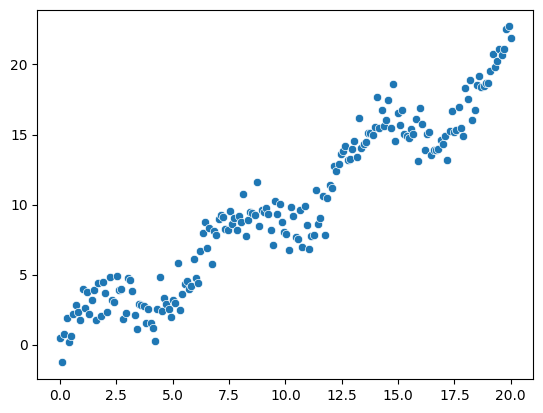

In [3]:
# datos simulados para un problema de regresion
X = np.linspace(0, 20 , num=200)
y = X + np.sin(X)*2 + np.random.normal(size=X.shape)
sns.scatterplot(x=X, y=y)

In [4]:
class Simple1DRegressionDataset(Dataset):
    def __init__(self, X, y):
        super(Simple1DRegressionDataset, self).__init__()
        self.X = X.reshape(-1, 1)
        self.y = y.reshape(-1, 1)

    def __getitem__(self, index):
        return (
            torch.tensor(self.X[index, :], dtype=torch.float32),
            torch.tensor(self.y[index], dtype=torch.float32)    
        )
    
    def __len__(self):
        return self.X.shape[0]

In [5]:
training_dataloader = DataLoader(Simple1DRegressionDataset(X, y), shuffle=True)

In [6]:
in_features = 1
out_features = 1
model = nn.Linear(in_features, out_features)
loss_func = nn.MSELoss()

device = torch.device('cpu')
train_simple_network(model, loss_func, training_dataloader, device=device)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

<Axes: >

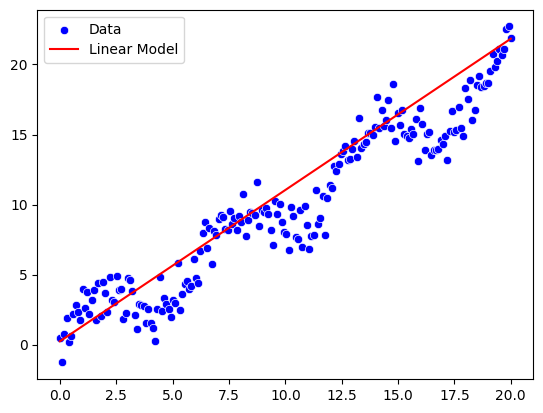

In [7]:
with torch.no_grad():
    Y_pred = model(torch.tensor(X.reshape(-1, 1), device=device, dtype=torch.float32)).cpu().numpy()

sns.scatterplot(x=X, y=y, color='blue', label='Data')
# ravel to remove the lowest shape
sns.lineplot(x=X, y=Y_pred.ravel(), color='red', label='Linear Model') 

In [8]:
# agregando un modelo un poco mas complejo
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.Linear(10, 1)
)
train_simple_network(model, loss_func, training_dataloader, device=device)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

<Axes: >

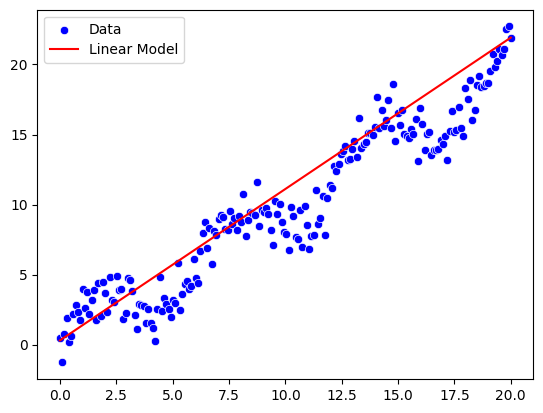

In [9]:
with torch.no_grad():
    Y_pred = model(torch.tensor(X.reshape(-1, 1), device=device, dtype=torch.float32)).cpu().numpy()

sns.scatterplot(x=X, y=y, color='blue', label='Data')
# ravel to remove the lowest shape
sns.lineplot(x=X, y=Y_pred.ravel(), color='red', label='Linear Model') 

El resultado no es mejor de lo que ya se tenia actualmente, realmente al tener dos `nn.Linear` de esta forma se termina teniendo una misma estructura lineal. No se puede captar la no linealidad de la funcion con solo eso.

Por esto es que es util utilizar funciones de activacion, como la funcion sigmoide, la tangente hiperbolica, la funcion ReLU, etc.

<Axes: >

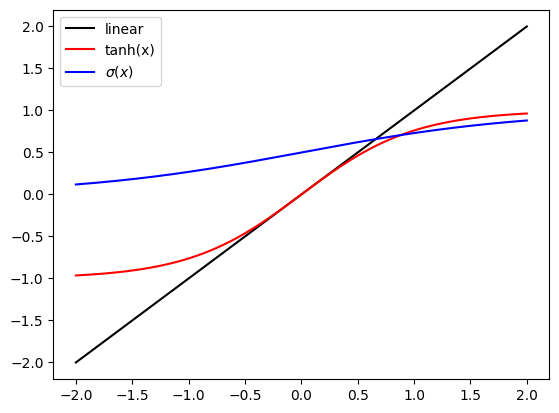

In [10]:
# graficas de funciones de activacion
activation_input = np.linspace(-2, 2, 200)
tanh_activation = np.tanh(activation_input)
sigmoid_activation = np.exp(activation_input)/(np.exp(activation_input) + 1)

sns.lineplot(x=activation_input, y=activation_input, color='black', label='linear')
sns.lineplot(x=activation_input, y=tanh_activation, color='red', label='tanh(x)')
sns.lineplot(x=activation_input, y=sigmoid_activation, color='blue', label='$\sigma(x)$')


In [11]:
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.Tanh(),
    nn.Linear(10, 1)
)

train_simple_network(model, loss_func, training_dataloader, epochs=200, device=device)

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

<Axes: >

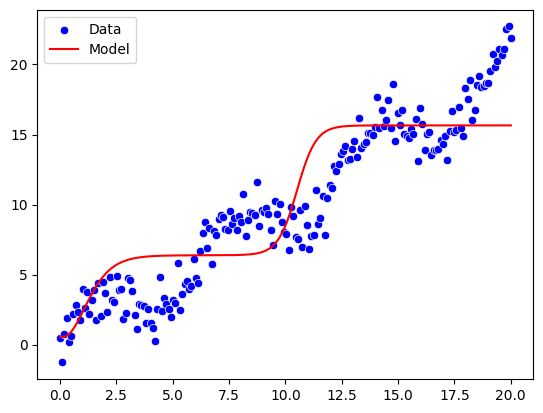

In [12]:
with torch.no_grad():
    Y_pred = model(torch.tensor(X.reshape(-1, 1), dtype=torch.float32, device=device)).cpu().numpy()

sns.scatterplot(x=X, y=y, color='blue', label='Data')
sns.lineplot(x=X, y=Y_pred.ravel(), color='red', label='Model')

#### Classification problem

In [13]:
from sklearn.datasets import make_moons

<Axes: >

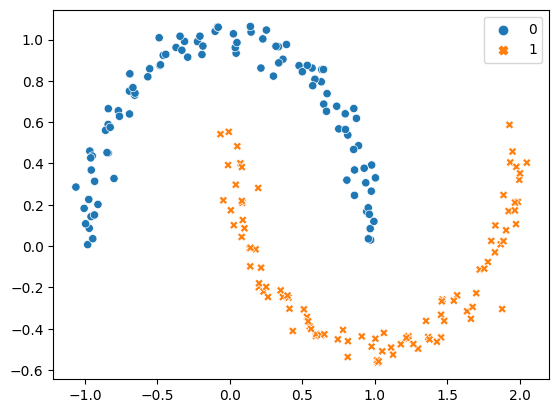

In [14]:
X, y = make_moons(n_samples=200, noise=0.05)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, style=y)

In [15]:
classification_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)
)
training_loader = DataLoader(classification_dataset)

In [16]:
in_features = 2
out_features = 2
model = nn.Linear(in_features, out_features)

In [17]:
loss_func = nn.CrossEntropyLoss()
train_simple_network(model, loss_func, training_loader, epochs=50, device=device)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

In [18]:
def visualize2DSoftmaxFabio(X, y, model, title=None):
    x_min = np.min(X[:, 0]) - 0.5
    x_max = np.max(X[:, 0]) + 0.5
    y_min = np.min(X[:, 1]) - 0.5
    y_max = np.max(X[:, 1]) + 0.5
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20),
                         np.linspace(y_min, y_max, num=20), indexing='ij')
    xy_v = np.hstack((xv.reshape(-1, 1), yv.reshape(-1, 1)))
    with torch.no_grad():
        preds = model(torch.tensor(xy_v, dtype=torch.float32))
        preds = F.softmax(preds, dim=1).numpy()
    
    cs = plt.contourf(xv, yv, preds[:, 0].reshape(20, 20),
                     levels=np.linspace(0, 1, num=20), cmap=plt.cm.RdYlBu)
    ax = plt.gca()
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, style=y, ax=ax)
    if title is not None:
        ax.set_title(title)

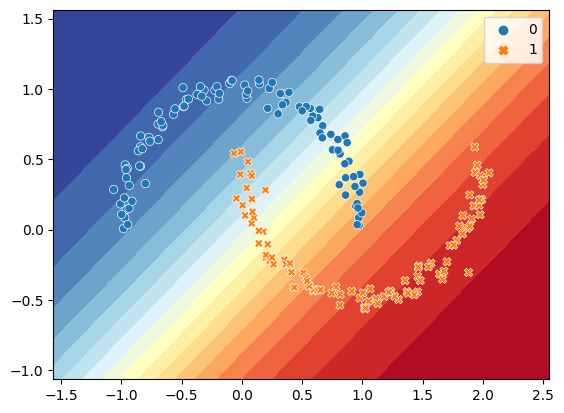

In [19]:
visualize2DSoftmaxFabio(X, y, model)

In [20]:
model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2)
)

train_simple_network(model, loss_func, training_loader, epochs=250, device=device)

Epoch:   0%|          | 0/250 [00:00<?, ?it/s]

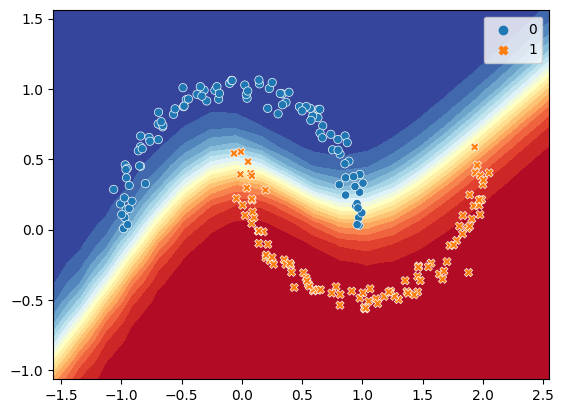

In [21]:
visualize2DSoftmaxFabio(X, y, model)

In [22]:
# ya la idea es usar el codigo mas pulido que provee el autor
# en el capitulo correspondiente, se explica mas la logica del codigo.
from idlmam import *  
from sklearn.metrics import accuracy_score, f1_score

In [23]:
X_train, y_train = make_moons(n_samples=8000, noise=0.4)
X_test, y_test = make_moons(n_samples=200, noise=0.4)
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)
training_loader = DataLoader(train_dataset, shuffle=True)
testing_loader = DataLoader(test_dataset)
model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2)
)
result_pd = train_simple_network(
    model,
    loss_func,
    training_loader,
    epochs=5,
    test_loader=testing_loader,
    checkpoint_file='model.pt',
    score_funcs={'Acc': accuracy_score, 'F1': f1_score}
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

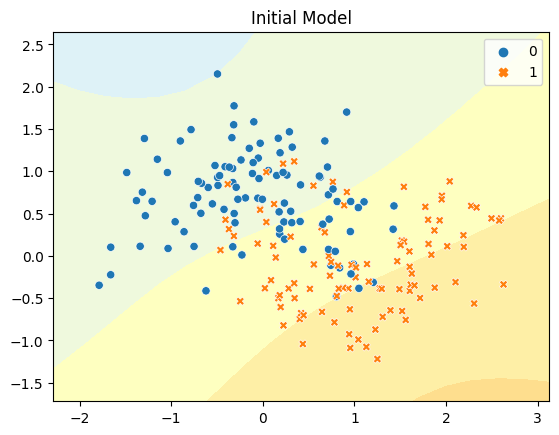

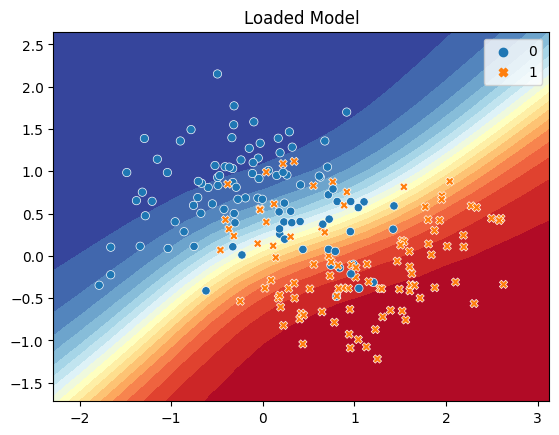

In [25]:
# este seria el procedimiento para cargar el modelo
model_new = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2)
)
visualize2DSoftmaxFabio(X_test, y_test, model_new, title='Initial Model')
plt.show()

# para cargar un modelo, en este caso solo se usa el model_state_dict, porque no nos
# interesa seguir optimizando, caso contrario deberiamos pedir informacion acerca
# del optimizer_state_dict (ver la funcion correspondiente en idlmam.py)
checkpoint_dict = torch.load('model.pt', map_location=device)
model_new.load_state_dict(checkpoint_dict['model_state_dict'])
visualize2DSoftmaxFabio(X_test, y_test, model_new, title='Loaded Model')
plt.show()

In [27]:
# vista de los resultados
result_pd

,epoch,total time,train loss,test loss,train Acc,test Acc,train F1,test F1
0,0,1.128839,0.424793,0.403521,0.811875,0.825,0.812180,0.818653
1,1,2.201970,0.383090,0.405242,0.833125,0.825,0.833811,0.818653
2,2,3.278886,0.381086,0.402263,0.834000,0.830,0.834455,0.824742
3,3,4.382175,0.378705,0.403398,0.833625,0.825,0.834556,0.818653
4,4,5.464690,0.375940,0.396865,0.835625,0.835,0.836096,0.830769


<Axes: xlabel='epoch', ylabel='train Acc'>

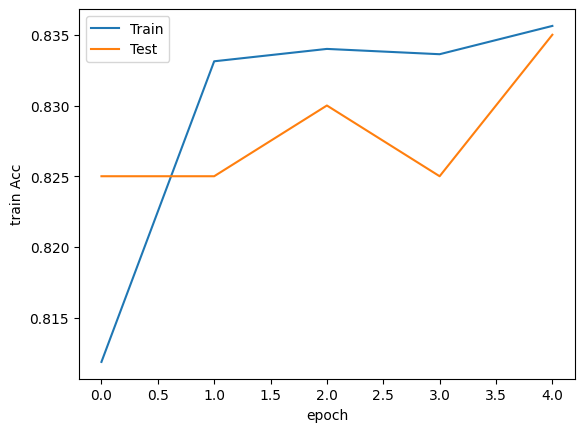

In [28]:
sns.lineplot(x='epoch', y='train Acc', data=result_pd, label='Train')
sns.lineplot(x='epoch', y='test Acc', data=result_pd, label='Test')

<Axes: xlabel='epoch', ylabel='train F1'>

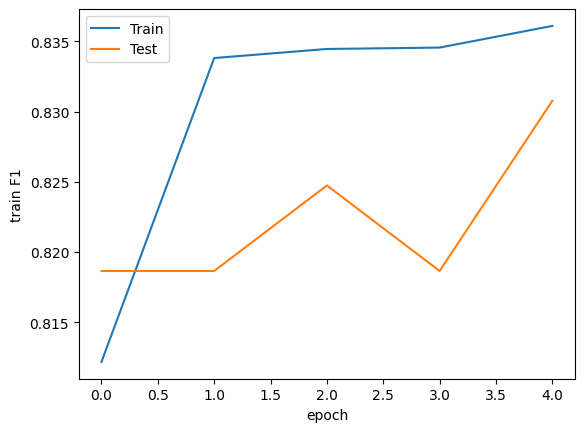

In [29]:
sns.lineplot(x='epoch', y='train F1', data=result_pd, label='Train')
sns.lineplot(x='epoch', y='test F1', data=result_pd, label='Test')

In [33]:
training_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
model_gd = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2)
)
results_true_gd = train_simple_network(
    model_gd,
    loss_func,
    training_loader,
    epochs=5,
    test_loader=testing_loader,
    checkpoint_file='model.pt',
    score_funcs={'Acc': accuracy_score, 'F1': f1_score}
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

<Axes: xlabel='total time', ylabel='test Acc'>

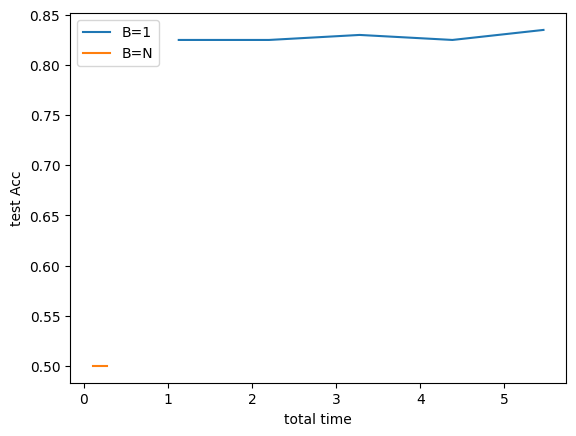

In [38]:
sns.lineplot(x='total time', y='test Acc', data=result_pd, label='B=1')
sns.lineplot(x='total time', y='test Acc', data=results_true_gd, label='B=N')

In [39]:
training_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
model_sgd = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2)
)
results_batched = train_simple_network(
    model_gd,
    loss_func,
    training_loader,
    epochs=5,
    test_loader=testing_loader,
    checkpoint_file='model.pt',
    score_funcs={'Acc': accuracy_score, 'F1': f1_score}
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

<Axes: xlabel='total time', ylabel='test Acc'>

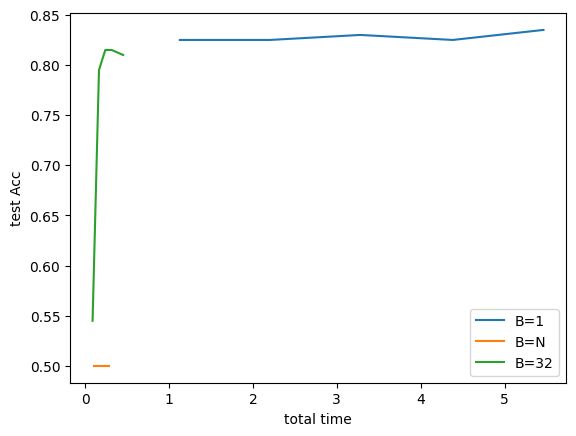

In [40]:
sns.lineplot(x='total time', y='test Acc', data=result_pd, label='B=1')
sns.lineplot(x='total time', y='test Acc', data=results_true_gd, label='B=N')
sns.lineplot(x='total time', y='test Acc', data=results_batched, label='B=32') # el mejor de los dos mundos